<a href="https://colab.research.google.com/github/adaribhanu/Human-Scream-Detection/blob/main/Human_Screaming_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
good_screams_dir = '/content/drive/MyDrive/datasets/scream/'
bad_screams_dir = '/content/drive/MyDrive/datasets/non_scream/'

In [ ]:
import os

# Check if directories exist
print("Good Screams Directory exists:", os.path.exists(good_screams_dir))
print("Bad Screams Directory exists:", os.path.exists(bad_screams_dir))

# List files in the directories
print("Files in Good Screams Directory:", os.listdir(good_screams_dir)[:10])  # List first 10 files
print("Files in Bad Screams Directory:", os.listdir(bad_screams_dir)[:10])  # List first 10 files


Good Screams Directory exists: True
Bad Screams Directory exists: True
Files in Good Screams Directory: ['1519.wav', '1531.wav', '152.wav', '1527.wav', '1523.wav', '1528.wav', '1525.wav', '1530.wav', '1526.wav', '1524.wav']
Files in Bad Screams Directory: ['1483.wav', '1484.wav', '150.wav', '1490.wav', '1480.wav', '1498.wav', '1491.wav', '1487.wav', '1502.wav', '1499.wav']


# Labelling the Data

In [ ]:
import time
import psutil
import numpy as np
import pandas as pd
import os
import torchaudio

# Define dataset directories
positive = '/content/drive/MyDrive/datasets/scream/'  # Positive sound directory
negative = '/content/drive/MyDrive/datasets/non_scream/'  # Negative sound directory

class Scream:
    def adder(self):
        """Load positive and negative sound files, convert to numerical format, and save dataset."""
        if not os.path.exists(negative):
            print(f"Error: Negative dataset directory {negative} does not exist.")
            return

        if not os.path.exists(positive):
            print(f"Error: Positive dataset directory {positive} does not exist.")
            return

        arr = []

        ################################ Getting negative sounds ################################
        print("Processing negative sounds...")
        self.process_files(negative, 0.0, arr)

        ################################ Getting positive sounds ################################
        print("Processing positive sounds...")
        self.process_files(positive, 1.0, arr)

        self.starting_index_not_to_be_shuffled = self.ctr

        with open("beginning_index_of_testing_files.txt", "w") as file:
            file.write(str(self.ctr))

        print(f"{self.ctr} files have been added.")

        ################################### Save DataFrame #####################################
        df = pd.DataFrame(arr)
        print(psutil.virtual_memory())

        df = df.dropna(axis=1)  # Remove columns containing null values
        df.to_csv('resources.csv', index=False)

    def process_files(self, directory, label, arr):
        """Process audio files from a given directory, convert them to numerical data, and store them."""
        files = os.listdir(directory)
        for file in files:
            filepath = os.path.join(directory, file)
            try:
                waveform, sample_rate = torchaudio.load(filepath)  # Use torchaudio to load audio
                print(f"Loaded {filepath} - Sample rate: {sample_rate}, Shape: {waveform.shape}")
                print(psutil.virtual_memory())

                waveform = waveform.mean(dim=0).numpy()  # Convert to NumPy array (Mono)
                waveform = np.insert(waveform, 0, label)  # Insert label at the beginning
                arr.append(pd.Series(waveform))
                self.ctr += 1
            except Exception as e:
                print(f"Removed {filepath} due to error: {e}")
                os.remove(filepath)

    def __init__(self):
        self.ctr = 0
        self.starting_index_not_to_be_shuffled = 0
        self.adder()
        start_time = time.time()

        print("Started processing dataset")
        self.df = pd.read_csv('resources.csv', engine='c')

        print(f"Without shuffling, dataset contains {len(self.df)} rows and {len(self.df.columns)} columns.")

        self.df.iloc[:self.starting_index_not_to_be_shuffled, :] = (
            self.df.iloc[:self.starting_index_not_to_be_shuffled, :].sample(frac=1).reset_index(drop=True)
        )  # Shuffle only a portion

        print(f"After shuffling, dataset contains {len(self.df)} rows and {len(self.df.columns)} columns.")

        self.df.to_csv('newresources.csv', index=False)  # Save shuffled dataset
        print(self.df.head())

        with open("input_dimension_for_model.txt", "w") as file:
            file.write(str(len(self.df.columns) - 1))

        print(f"\nWhole process took {time.time() - start_time:.2f} seconds.")

# Run the script
Scream()


Streaming output truncated to the last 5000 lines.
Loaded /content/drive/MyDrive/datasets/non_scream/654.wav - Sample rate: 16000, Shape: torch.Size([2, 28600])
svmem(total=13609431040, available=11029323776, percent=19.0, used=2245271552, free=4479528960, active=960376832, inactive=7763099648, buffers=430137344, cached=6454493184, shared=1613824, slab=279343104)
Loaded /content/drive/MyDrive/datasets/non_scream/647.wav - Sample rate: 16000, Shape: torch.Size([2, 31760])
svmem(total=13609431040, available=11029155840, percent=19.0, used=2245435392, free=4479270912, active=960499712, inactive=7763259392, buffers=430137344, cached=6454587392, shared=1613824, slab=279343104)
Loaded /content/drive/MyDrive/datasets/non_scream/639.wav - Sample rate: 16000, Shape: torch.Size([2, 24888])
svmem(total=13609431040, available=11028848640, percent=19.0, used=2245664768, free=4479012864, active=960733184, inactive=7763226624, buffers=430137344, cached=6454616064, shared=1613824, slab=279343104)
Load

MFCCs extraction

In [ ]:
import pandas as pd
import torchaudio.transforms as T
import torch

# Load the dataset
df = pd.read_csv('newresources.csv')

# Extract the waveform and labels
# Assuming the label is in the first column and the waveform data in the rest of the columns
labels = df.iloc[:, 0].values  # Labels
waveforms = df.iloc[:, 1:].values  # Waveform data

# Convert waveform data to torch tensors
waveforms_tensor = torch.tensor(waveforms, dtype=torch.float32)

# Apply MFCC transformation to the waveform data (if you want features for training)
transform = T.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False}
)

# Apply MFCC transformation (assuming all waveforms are already of a consistent length)
mfcc_features = []
for waveform in waveforms_tensor:
    waveform_tensor = waveform.unsqueeze(0)  # Add a batch dimension
    mfcc = transform(waveform_tensor)
    mfcc_features.append(mfcc)

# Convert the list of MFCC features to a tensor
mfcc_features_tensor = torch.stack(mfcc_features)

# You can now use the MFCC features (mfcc_features_tensor) and labels for model training
print(f'MFCC features shape: {mfcc_features_tensor.shape}')



MFCC features shape: torch.Size([3140, 1, 13, 11])


Plotting Spectrogram

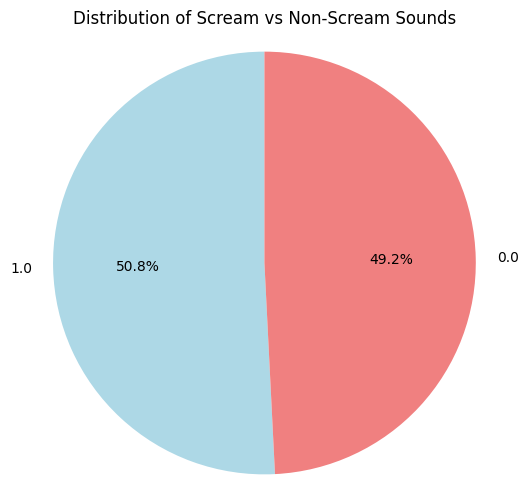

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


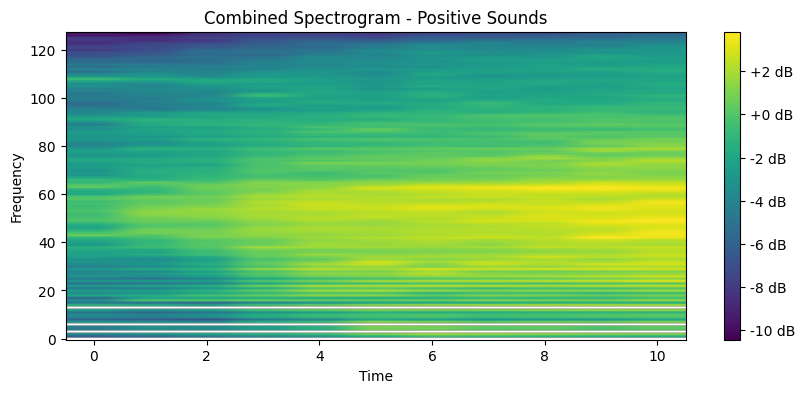

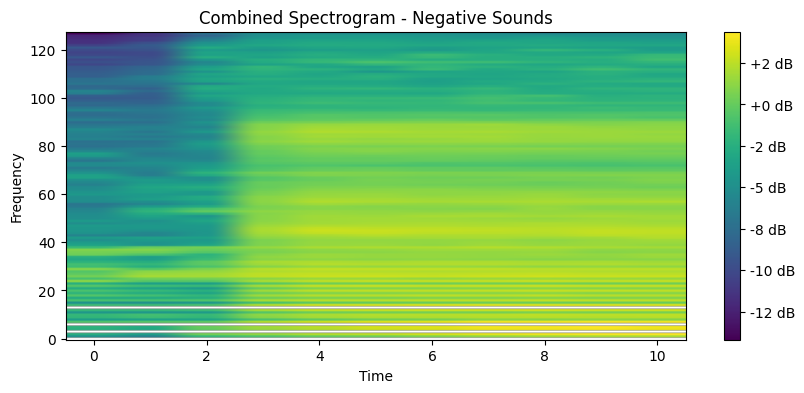

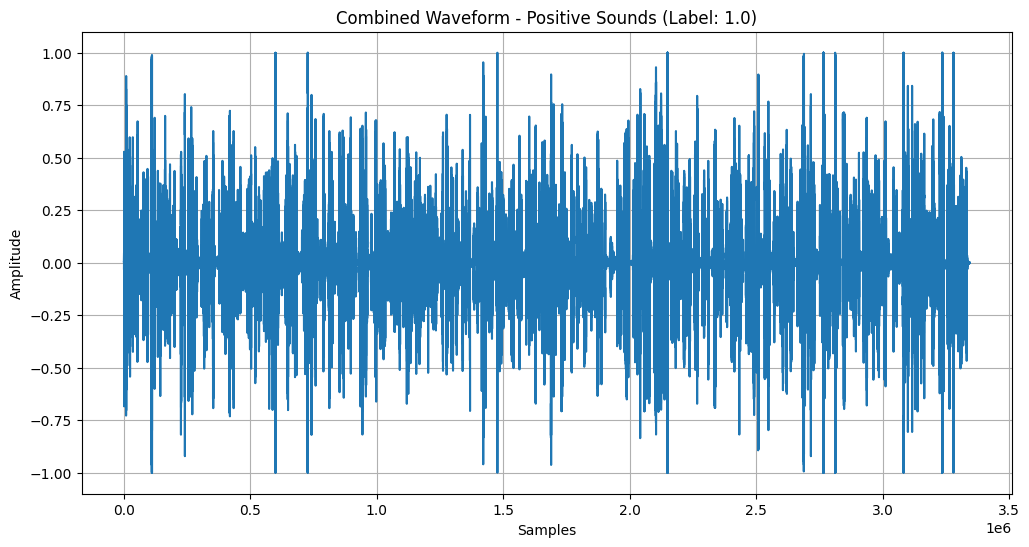

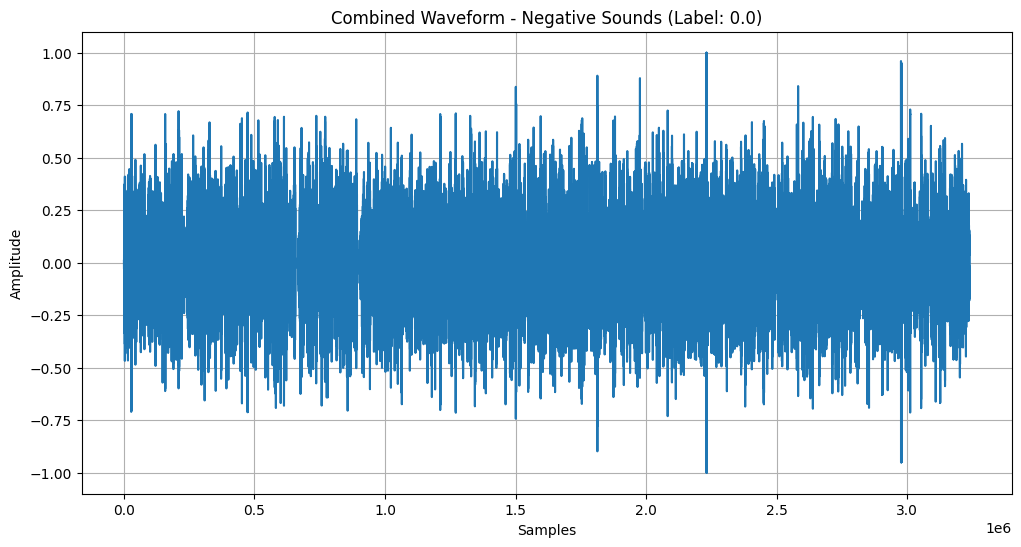

AttributeError: module 'torchaudio.transforms' has no attribute 'ZeroCrossingRate'

In [ ]:
import pandas as pd
import torchaudio
import torch
import matplotlib.pyplot as plt

import seaborn as sns
import torchaudio.transforms as T

# Load the CSV file with the waveform data
df = pd.read_csv('newresources.csv')

# Assuming the first column contains the labels and the remaining columns contain the waveform data
# Convert each row into a tensor (waveform)
audio_data = df.iloc[:, 1:].values  # Get all columns except the first (labels)
labels = df.iloc[:, 0].values  # The first column is for labels
label_counts = pd.Series(labels).value_counts()




plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title("Distribution of Scream vs Non-Scream Sounds")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

# Separate positive (1.0) and negative (0.0) sound samples
positive_sounds = df[df.iloc[:, 0] == 1.0]  # First column is the label
negative_sounds = df[df.iloc[:, 0] == 0.0]

# Function to compute and plot the combined spectrogram
def plot_combined_spectrogram(sounds, label, title):
    spectrograms = []

    # Loop over the sounds and compute the spectrogram for each
    for idx, row in sounds.iterrows():
        waveform = torch.tensor(row.iloc[1:].values, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add batch dimension
        # Compute the MelSpectrogram
        spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)
        # Remove batch dimension (which is of size 1)
        spectrogram = spectrogram.squeeze(0)
        spectrograms.append(spectrogram)

    # Stack the spectrograms and compute the mean
    combined_spectrogram = torch.stack(spectrograms).mean(dim=0)

    # Plot the combined spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(combined_spectrogram.log2(), cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Combined Spectrogram - {title}")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

# Plot combined spectrogram for positive samples
plot_combined_spectrogram(positive_sounds, 1.0, "Positive Sounds")

# Plot combined spectrogram for negative samples
plot_combined_spectrogram(negative_sounds, 0.0, "Negative Sounds")

def plot_combined_waveform(sounds, label, title):

    # Create an empty tensor to accumulate the combined waveform
    combined_waveform = torch.tensor([])

    # Loop over each row and combine the waveforms
    for idx, row in sounds.iterrows():
        waveform = torch.tensor(row.iloc[1:].values, dtype=torch.float32)
        combined_waveform = torch.cat((combined_waveform, waveform))  # Concatenate the waveforms

    # Plot the combined waveform for all samples
    plt.figure(figsize=(12, 6))
    plt.plot(combined_waveform.numpy())
    plt.title(f"Combined Waveform - {title} (Label: {label})")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

# Plot combined waveforms for positive and negative samples
plot_combined_waveform(positive_sounds, 1.0, "Positive Sounds")
plot_combined_waveform(negative_sounds, 0.0, "Negative Sounds")





# Convert each row of waveform values into PyTorch tensors
waveforms_tensor = [torch.tensor(row[1:].values, dtype=torch.float32) for _, row in df.iterrows()]

# Separate positive (1) and negative (0) waveforms
positive_waveforms = [waveform for i, waveform in enumerate(waveforms_tensor) if df.iloc[i, 0] == 1.0]
negative_waveforms = [waveform for i, waveform in enumerate(waveforms_tensor) if df.iloc[i, 0] == 0.0]

# ✅ Method 1: Using ZeroCrossingRate (If Available)
def plot_combined_zcr(sounds, title):
    zcr_transform = T.ZeroCrossingRate()  # Default hop_length = 512
    zcr_values = [zcr_transform(waveform.unsqueeze(0)).mean().item() for waveform in sounds]

    plt.figure(figsize=(8, 6))
    plt.plot(zcr_values, marker='o', linestyle='-', color='purple')
    plt.title(f"Zero Crossing Rate - {title}")
    plt.xlabel("Sample Index")
    plt.ylabel("Zero Crossing Rate")
    plt.grid(True)
    plt.show()

# ✅ Method 2: Manual Calculation (If ZCR Is Missing)
def zero_crossing_rate(waveform):
    zero_crossings = torch.sum(torch.diff(torch.sign(waveform)) != 0)
    return zero_crossings / waveform.numel()

def plot_manual_zcr(sounds, title):
    zcr_values = [zero_crossing_rate(w) for w in sounds]

    plt.figure(figsize=(8, 6))
    plt.plot(zcr_values, marker='o', linestyle='-', color='green')
    plt.title(f"Zero Crossing Rate - {title}")
    plt.xlabel("Sample Index")
    plt.ylabel("Zero Crossing Rate")
    plt.grid(True)
    plt.show()

# 🟣 Plot Using Torchaudio or Manual Method
plot_combined_zcr(positive_waveforms, "Positive Screams")    # Torchaudio Method
plot_combined_zcr(negative_waveforms, "Negative Screams")

# plot_manual_zcr(positive_waveforms, "Positive Screams")    # Manual Method
# plot_manual_zcr(negative_waveforms, "Negative Screams")

In [ ]:
labels_encoded = labels.astype(int)
print(type(labels_encoded[0]))

In [ ]:
import pandas as pd
import torchaudio.transforms as T
import torch
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# -------------------- 1. Load Dataset --------------------
df = pd.read_csv('newresources.csv')

# Extract labels and waveform data
labels = df.iloc[:, 0].values  # Labels (0 = noise, 1 = non-noise)
waveforms = df.iloc[:, 1:].values  # Waveform data

# Convert waveforms to torch tensor
waveforms_tensor = torch.tensor(waveforms, dtype=torch.float32)

# -------------------- 2. Extract MFCC Features --------------------
transform = T.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False}
)

mfcc_features = []
for waveform in waveforms_tensor:
    waveform_tensor = waveform.unsqueeze(0)  # Add batch dimension
    mfcc = transform(waveform_tensor)
    mfcc_features.append(mfcc.squeeze().flatten())  # Flatten to 1D

# Convert MFCC features to numpy array
mfcc_features_tensor = torch.stack(mfcc_features).numpy()

# -------------------- 3. Prepare Labels --------------------
labels_encoded = [int(label) for label in labels]  # Ensure labels are integers

# -------------------- 4. Split Dataset --------------------
X_train, X_test, y_train, y_test = train_test_split(mfcc_features_tensor, labels_encoded, test_size=0.2, random_state=42)

# -------------------- 5. Train SVM Classifier --------------------
svm = SVC(kernel='linear')  # Linear kernel for binary classification
svm.fit(X_train, y_train)

# -------------------- 6. Evaluate Model --------------------
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(report)


Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       328
           1       0.79      0.82      0.81       300

    accuracy                           0.81       628
   macro avg       0.81      0.81      0.81       628
weighted avg       0.81      0.81      0.81       628

